## Transmon state

We consider a superconducting transmon system with two-qutrit computational basis $\{\ket{00},\ket{01},\dots,\ket{12},\ket{22}\}$ described by the Hamiltonian
$$\hat{H}_n = \left[\Delta\hat{b}^\dagger_1\hat{b}_1+\frac{1}{2}\sum_{j=1,2}\delta_j\hat{b}^\dagger_j\hat{b}_j(\hat{b}^\dagger_j\hat{b}_j-1)+J(\hat{b}^\dagger_1\hat{b}_2+\hat{b}_1\hat{b}^\dagger_2)\right]+u_n(\hat{b}^\dagger_1+\hat{b}_1)=\hat{H}_d+\hat{H}^c_n\;,$$
with the parameters as in [Hessian-based optimization of constrained quantum control](https://arxiv.org/pdf/2006.00935.pdf). We consider the state transfer
\begin{equation*}
\ket{\psi_{\mathrm{ini}}}=\ket{10}\longrightarrow\ket{\psi_{\mathrm{tgt}}}=\ket{11}\;,
\end{equation*}
i.e. a single state mapping of a CNOT gate in the qubit subspace $\{\ket{00},\ket{01},\ket{10},\ket{11}\}$, without control constraints (except at the endpoints).

Note that the control Hamiltonian is not diagonal in the natural computational basis. To obtain a proper representation for the Trotter exact derivatives we therefore numerically diagonalize $\hat{H}^c_n=u_n(\hat{b}^\dagger_1+\hat{b}_1)$.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('science')
from mpl2latex import mpl2latex, latex_figsize
mpl2latex()

import numpy as np
from numpy import array, ndarray
from numpy.linalg import norm
from scipy.sparse import dia_matrix, kron, identity
from scipy.sparse.linalg import expm
from scipy.sparse import csc_matrix
from scipy.linalg import eigh
from scipy.optimize import fmin_l_bfgs_b
from tqdm.notebook import trange

### Initialization

In [2]:
def input_parameters(Nt: int, T: int):
    '''
    Defines input parameters for the simulation

    Parameters
    ----------
    Nt : int
        nr of time steps & nr of time-evolving unitary operators
    T : int
        time window in units of pi

    Returns
    -------
    N : int
        nr of elements of the wave functions
    delta_t : float
        time interval computed as T / (N+1)

    Controls are N (Nt) for the trapezoidal (rectangular) rule
    '''
    N = Nt + 1
    delta_t = T / Nt

    print('# time steps:\t', Nt)
    print('time step:\t', np.round(delta_t,5))

    return N, delta_t

In [3]:
# time interval T is given in numerical units
N, delta_t = input_parameters(Nt=100, T=2.83)

N_trap = N
N_rect = N - 1

# time steps:	 100
time step:	 0.0283


In [4]:
# global dimension
dim = 2
# local dimension
d = 3
# Hilbert space dimension
D_H = d**dim

In [5]:
# Hamiltonian parameters
twopi = 2 * np.pi
omega_1 = 5 * twopi
omega_2 = 5.5 * twopi
delta_1 = -0.35 * twopi
omega_r = 7.5 * twopi
g_1 = 0.1 * twopi
g_2 = g_1

Delta_1 = omega_1 - omega_r
Delta_2 = omega_2 - omega_r
omega_tilde_1 = omega_1 + (g_1**2 / Delta_1)
omega_tilde_2 = omega_2 + (g_2**2 / Delta_2)

J = (g_1 * g_2 * (Delta_1 + Delta_2)) / (Delta_1 * Delta_2)
Delta = omega_tilde_2 - omega_tilde_1

In [6]:
# scaling constants
e_unit = np.abs(J)

# re-scale Hamiltonian constants
Delta = Delta / e_unit
delta_1 = delta_1 / e_unit
delta_2 = delta_1
J = J / e_unit

In [7]:
def initialize_controls_register(n: int, n_iter: int, u_start: ndarray or None=None) -> ndarray:
    '''
    Initializes register to keep track of the control vector(s)
    through each iteration of the optimization algorithm
    
    Parameters
    ----------
    n : int
        number of time steps (length of the control vector)
    n_iter : int
        number of iterations of the optimization algorithm
    u_start : array, optional
        initial vector of controls
    
    Returns
    -------
    u : array
        register of dimensions [iterations × nr of controls × nr of time steps]

    Row-major ordering: first index is the one of the nr of iterations, allowing for faster access.
    '''
    # J = len(H_ops) # number of control operators
    J = 1
    u = np.zeros((n_iter, J, n))
    if u_start is not None:
        for idx, u0 in enumerate(u_start):
            u[0, idx, :] = u0
    return u

def initialize_controls(n: int, u_start: ndarray or None=None) -> ndarray:
    '''
    Initializes vector of controls

    Parameters
    ----------
    n : int
        number of time steps (length of the control vector)
    u_start : array, optional
        initial vector of controls
    
    Returns
    -------
    u : array
        register of dimensions [nr of time steps × nr of controls]
    '''
    u = np.zeros((n, 1))
    if u_start is not None:
        for idx, u0 in enumerate(u_start):
            u[idx, :] = u0
    return u

In [8]:
def abs2(x: ndarray) -> ndarray:
    '''
    Returns the element-wise square modulus of an array
    '''
    return x.real**2 + x.imag**2

### Operators and Hamiltonian definition

In [9]:
def annihilation_sparse(dimension: int) -> csc_matrix:
    '''
    Returns the annihilation operator in sparse matrix form
    '''
    offdiag_elements = np.sqrt(range(dimension))
    return dia_matrix((offdiag_elements, [1]), shape=(dimension, dimension)).tocsc()

def creation_sparse(dimension: int) -> csc_matrix:
    '''
    Returns the creation operator in sparse matrix form
    '''
    return annihilation_sparse(dimension).transpose().tocsc()

In [10]:
# define creation and annihilation operators
b = annihilation_sparse(d)
bdg = creation_sparse(d)
bdgb = bdg @ b

The function `scipy.sparse.linalg.eigs` is incompatible with our scopes. This function use the Implicitly Restarted Arnoldi Method to find the eigenvalues and eigenvectors. The algorithm is capable of computing a few ($k$) eigenvalues with user specified features such as largest real part or largest magnitude using storage. For this reason, the eigenvalues are computed in the dense representation.

The eigenvectors are identical for all nonzero values of the control and we take $u_n=1$ for simplicity. The eigenvalues are equal up to a factor $u_n$: this property is used to compute their values only once.

In [11]:
# compute eigenvalue/vectors in dense representation
Hc = (b + bdg).toarray()
e, R = eigh(Hc)
Hc = csc_matrix(Hc)

def rotate(arg: csc_matrix) -> csc_matrix:
    '''
    Returns the rotated operator accoding to Jensen's formalism
    '''
    return R.T @ arg @ R

In [12]:
# the control Hamiltonian is diagonal by the problem definition
diag_Hc = rotate(Hc)
Hc = kron(diag_Hc, identity(d)).diagonal()

# back to sparse representation
R = csc_matrix(R)

# drift Hamiltonian is defined sparsely
drift1 = Delta * kron(rotate(bdgb), identity(d), format='csc')
drift21 = 1/2 * delta_1 * kron(rotate(bdgb @ (bdgb - identity(d))), identity(d), format='csc')
drift22 = 1/2 * delta_2 * kron(identity(d), bdgb @ (bdgb - identity(d)), format='csc')
drift2 = drift21 + drift22
drift3 = J * (kron(rotate(bdg), b, format='csc') + kron(rotate(b), bdg, format='csc'))
Hd = (drift1 + drift2 + drift3)

# pre-compute matrix exponentials
expHd = expm(-1j * Hd * delta_t)
expHdconj = np.conj(expHd.T)

# define initial and target states
psi_ini = np.kron(R.T @ array([0,1,0]), array([1,0,0]))
psi_tgt = np.kron(R.T @ array([0,1,0]), array([0,1,0]))

In [13]:
# some useful checks
print('max difference (diag(Hc) - eigs):\t', np.max(np.diag(diag_Hc) - e))
eps = np.finfo(float).eps
print('numpy.float64 machine precision:\t', eps)

print('norm psi_ini:\t', norm(psi_ini))
print('norm psi_tgt:\t', norm(psi_tgt))

print('Hd hermitian:\t', np.max(Hd - np.conj(Hd.T)) < eps)
print('diag(adj(R) * R):\t', np.diag((R.T @ R).toarray()))

max difference (diag(Hc) - eigs):	 2.220446049250313e-16
numpy.float64 machine precision:	 2.220446049250313e-16
norm psi_ini:	 1.0
norm psi_tgt:	 1.0
Hd hermitian:	 True
diag(adj(R) * R):	 [1. 1. 1.]


### Integration rules, time evolution and gradient

In [14]:
class trapezoid:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = len(self.ctrl)                                                         # nr of evolutions = nr controls = Nt + 1 = N
        self.dim = D_H                                                                  # local dimension
        self.delta_t = delta_t                                                          # time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap = np.dot(np.conj(self.evolved_chi[-1]), self.evolved_psi[-1])      # overlap
        self.coverlap = np.conj(self.overlap)                                           # conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.dim), dtype=complex)                       # psi evolution vector
        evolved_chi = np.zeros((self.N, self.dim), dtype=complex)                       # chi evolution vector
        trotter = np.zeros((self.N-1, 2, self.dim), dtype=complex)                      # trotterized operators

        evolved_psi[0] = psi_ini                                                        # initialize evolutions
        evolved_chi[-1] = psi_tgt

        for n in range(1, self.N):                                                      # iterate over the control vector
            Hc_next = self.ctrl[n] * Hc
            Hc_curr = self.ctrl[n-1] * Hc
            a = np.exp(-1j * Hc_next * self.delta_t / 2)
            c = np.exp(-1j * Hc_curr * self.delta_t / 2)
            
            trotter[n-1] = a, c                                                         # save operator
            evolve_psi = lambda x: a * (expHd @ (c * x))                                # build trotterized propagator
            evolved_psi[n] = evolve_psi(evolved_psi[n-1])                               # evolve psi
            evolved_psi[n] = evolved_psi[n] / norm(evolved_psi[n])                      # impose normalization
            
        for n in range(self.N-1, 0, -1):
            a, c = trotter[n-1]
            evolve_chi = lambda x: np.conj(c) * (expHdconj @ (np.conj(a) * x))          # build trotterized propagator
            evolved_chi[n-1] = evolve_chi(evolved_chi[n])                               # evolve chi
            evolved_chi[n-1] = evolved_chi[n-1] / norm(evolved_chi[n-1])                # impose normalization
        
        return evolved_psi, evolved_chi

    def F(self):
        return np.real(self.overlap * self.coverlap)                                    # fidelity

    def gradient(self):
        sandwich = array([np.conj(self.evolved_chi[n]) @ (Hc * self.evolved_psi[n]) for n in range(self.N)])
        sandwich[0] = 1/2 * sandwich[0]
        sandwich[-1] = 1/2 * sandwich[-1]
        return np.real(1j * self.coverlap * sandwich) * self.delta_t                    # gradient

In [15]:
class rectangle:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = len(self.ctrl) + 1                                                     # nr of evolutions = nr of controls + 1 = Nt + 1 = N
        self.dim = D_H                                                                  # Hilbert space dimension
        self.delta_t = delta_t                                                          # pi re-scaled time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap = np.dot(np.conj(self.evolved_chi[-1]), self.evolved_psi[-1])      # overlap
        self.coverlap = np.conj(self.overlap)                                           # conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.dim), dtype=complex)                       # psi evolution vector
        evolved_chi = np.zeros((self.N, self.dim), dtype=complex)                       # chi evolution vector
        trotter = np.zeros((self.N-1, self.dim), dtype=complex)                         # trotterized operators

        evolved_psi[0] = psi_ini                                                        # initialize evolutions
        evolved_chi[-1] = psi_tgt

        for n in range(1, self.N):                                                      # iterate over the control vector
            a = np.exp(-1j * self.ctrl[n-1] * Hc * self.delta_t / 2)
            
            trotter[n-1] = a                                                            # save operators
            evolve_psi = lambda x: a * (expHd @ (a * x))                                # build trotterized propagator
            evolved_psi[n] = evolve_psi(evolved_psi[n-1])                               # evolve psi
            evolved_psi[n] = evolved_psi[n] / norm(evolved_psi[n])                      # impose normalization

        for n in range(self.N-1, 0, -1):
            a = np.conj(trotter[n-1])
            evolve_chi = lambda x: a * (expHdconj @ (a * x))                            # build trotterized propagator
            evolved_chi[n-1] = evolve_chi(evolved_chi[n])                               # evolve chi
            evolved_chi[n-1] = evolved_chi[n-1] / norm(evolved_chi[n-1])                # impose normalization

        return evolved_psi, evolved_chi

    def F(self):
        return np.real(self.overlap * self.coverlap)                                    # fidelity

    def gradient(self):
        sandwich = array([np.conj(self.evolved_chi[n]) @ (Hc * self.evolved_psi[n]) for n in range(self.N)])
        neighbor_sum = array([sandwich[n+1] + sandwich[n] for n in range(self.N-1)])
        return np.real(1j * self.coverlap * 1/2 * neighbor_sum) * self.delta_t          # gradient

In [16]:
# 200 MHz is set as upper/lower control threshold
u_thr = 0.2 * twopi

# normalize control interval
u_thr /= e_unit

In [17]:
# test for a random initial condition
np.random.seed(0)
rcontrol_start = np.random.uniform(-u_thr, u_thr, size=(N_trap))

trap = trapezoid(rcontrol_start)
rect = rectangle(rcontrol_start[:-1])

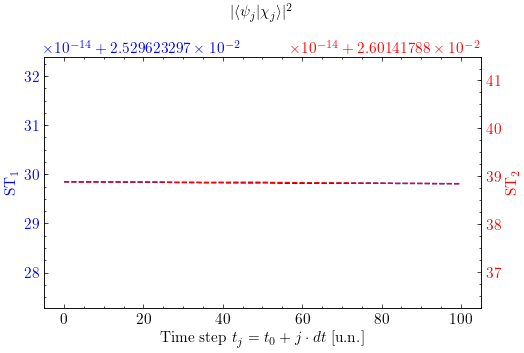

In [18]:
# verify validity of forward and backward time evolution
check_trap = abs2(array([np.dot(np.conj(trap.evolved_psi[n]), trap.evolved_chi[n]) for n in range(trap.N)]))
check_rect = abs2(array([np.dot(np.conj(rect.evolved_psi[n]), rect.evolved_chi[n]) for n in range(trap.N)]))

fig, ax1 = plt.subplots(figsize=latex_figsize(wf=1.1))

color = 'b'
ax1.set_xlabel('Time step $t_j=t_0+j\cdot dt$ [$\mathrm{u.n.}$]')
ax1.set_ylabel('$\mathrm{ST}_1$', color=color)
plt.plot(check_trap, color='b', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'r'
ax2.set_ylabel('$\mathrm{ST}_2$', color=color)
plt.plot(check_rect, color='r', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('$|\\langle\psi_j|\chi_j\\rangle|^2$\n')
plt.show()

### Optimal control
#### Steepest descent

In [19]:
iterations = 500

decay_rate = .96
decay_steps = 20

controls_trap = initialize_controls_register(N_trap, iterations, u_start=[rcontrol_start])
controls_rect = initialize_controls_register(N_rect, iterations, u_start=[rcontrol_start[:-1]])
fidelities_trap = np.zeros(iterations-1)
fidelities_rect = np.zeros(iterations-1)

In [20]:
for k in trange(iterations-1):
    # define trapezoid/rectangle class object
    u_trap = controls_trap[k, :, :][0]
    u_rect = controls_rect[k, :, :][0]
    trap = trapezoid(u_trap)
    rect = rectangle(u_rect)
    # compute fidelities
    fidelities_trap[k] = trap.F()
    fidelities_rect[k] = rect.F()
    # set alpha
    alpha = decay_rate**(k / decay_steps)
    # update control tensor: learning rates are set individually
    controls_trap[k+1, :, :][0] = u_trap - 80 * alpha * trap.gradient()
    controls_rect[k+1, :, :][0] = u_rect - 60 * alpha * rect.gradient()

  0%|          | 0/499 [00:00<?, ?it/s]

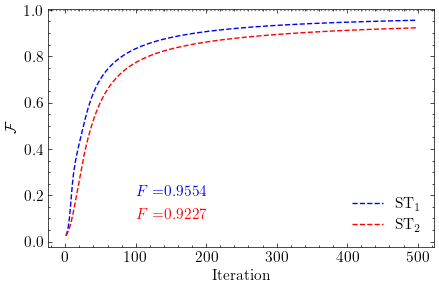

In [21]:
x = np.arange(1, iterations)
plt.figure(figsize=latex_figsize())
plt.plot(x, fidelities_trap, color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(x, fidelities_rect, color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.axhline(y=1, color='gray', linestyle='dotted')
plt.text(100, 0.2, '$F=${}'.format(np.round(fidelities_trap[-1],5)), color='b')
plt.text(100, 0.1, '$F=${}'.format(np.round(fidelities_rect[-1],5)), color='r')
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{F}$')
plt.legend()
plt.show()

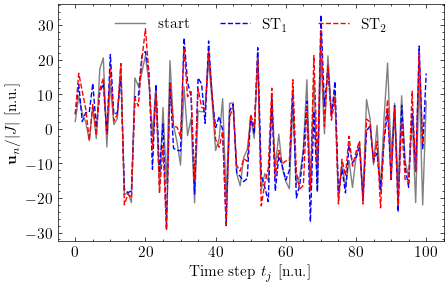

In [22]:
plt.figure(figsize=latex_figsize())
plt.plot(rcontrol_start, color='gray', label='start')
plt.plot(controls_trap[-1, :, :][0], color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(controls_rect[-1, :, :][0], color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')
plt.ylabel('$\mathbf{u}_n / |J|$ [$\mathrm{n.u.}$]')
plt.legend(ncols=3, loc='upper center')
plt.show()

#### L-BFGS-B search algorithm

In [23]:
# initial control vector
tcontrol_start = initialize_controls(n=N_trap, u_start=np.random.uniform(-u_thr, u_thr, size=N_trap))
rcontrol_start = tcontrol_start[:-1]

# control threshold
bounds_trap = [(-u_thr, u_thr) for _ in range(np.prod(tcontrol_start.shape))]
bounds_rect = bounds_trap[:-1]

In [24]:
# functions for the optimization algorithm
JF_trap = lambda u: 1/2 * (1 - trapezoid(u).F())
gradient_trap = lambda u: trapezoid(u).gradient()

JF_rect = lambda u: 1/2 * (1 - rectangle(u).F())
gradient_rect = lambda u: rectangle(u).gradient()

In [25]:
x_trap, f, d = fmin_l_bfgs_b(func=JF_trap, x0=tcontrol_start, fprime=gradient_trap, bounds=bounds_trap, m=17, factr=10.0, maxfun=900)
print('Trapezoid rule:')
print(' - simulation converged:\t', d['warnflag']==0)
print(' - number of iterations:\t', d['nit'])
print(' - final fidelity:\t', 1-2*f)

Trapezoid rule:
 - simulation converged:	 True
 - number of iterations:	 255
 - final fidelity:	 0.9999593405413599


In [26]:
x_rect, f, d = fmin_l_bfgs_b(func=JF_rect, x0=rcontrol_start, fprime=gradient_rect, bounds=bounds_rect, m=17, factr=10.0, maxfun=900)
print('\nRectangular rule:')
print(' - simulation converged:\t', d['warnflag']==0)
print(' - number of iterations:\t', d['nit'])
print(' - final fidelity:\t', 1-2*f)


Rectangular rule:
 - simulation converged:	 True
 - number of iterations:	 426
 - final fidelity:	 0.9999731497193867


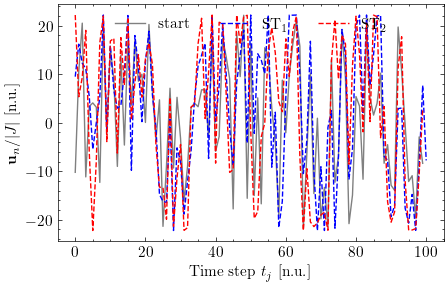

In [27]:
plt.figure(figsize=latex_figsize())
plt.plot(rcontrol_start, color='gray', label='start')
plt.plot(x_trap, color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(x_rect, color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')
plt.ylabel('$\mathbf{u}_n / |J|$ [$\mathrm{n.u.}$]')
plt.legend(ncols=3, loc='upper center')
plt.show()